In [14]:
import os
import sys
# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve
from multipy.fwer import sidak, hochberg
import random

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances, plot_volcano
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, split_data, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing, get_top_changed_clonotypes
from utils.clustering_utils import seqs2hamming
from utils.weblogo_utils import create_web_logo
from source.alpha_beta_paired_clones_search import make_metaclone_cm

from source.tests_analysis.significant_clonotype_matrix_creation import create_significant_clonotype_matrix

import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

<module 'utils.viz_utils' from '/home/evlasova/tcr-covid-classifier/utils/viz_utils.py'>

In [20]:
desc = prepare_run_column(pd.read_csv('data/desc_fmba_not_nan_hla.csv')).drop(columns=['Unnamed: 0'])

In [33]:
desc['covid'] = desc.COVID_status.str.lower()

In [22]:
train_runs = desc[~desc.folder.str.lower().str.contains('novaseq6')].run
test_runs = desc[desc.folder.str.lower().str.contains('novaseq6')].run

In [6]:
allele_names = ['A*02', 'A*01', 'A*03', 'A*24', 'B*07', 'B*35', 'B*44', 'B*18', 'C*07', 'C*04', 'C*12', 'DQB1*05', 'DRB1*16']

In [10]:
allele_to_clones_trb = {}
joint_clone_list = []
for allele in allele_names:
    clones = list(
        pd.read_csv(f'data/hla_associated_clones/hla_associated_clones_500k_top_1_mismatch_hla_{allele}.csv').clone)
    allele_to_clones_trb[allele] = clones
    joint_clone_list += clones

In [12]:
pd.DataFrame({'clone': joint_clone_list}).to_csv('data/hla_associated_clones.csv', index=False)

In [15]:
create_significant_clonotype_matrix(clonotype_matrix_path='data/clone_matrix_fmba_TRB_top_500k.csv', 
                                    significant_clones_path='data/hla_associated_clones.csv', 
                                    save_path='data/significant_clone_matrix_fisher_fmba_TRB_allele.csv')

In [26]:
beta_cm = prepare_run_column(pd.read_csv(
    'data/significant_clone_matrix_fisher_fmba_TRB_allele.csv').drop(columns=['Unnamed: 0']))

In [35]:
fold_change_beta = get_top_changed_clonotypes(clonotype_matrix=beta_cm[beta_cm.run.isin(train_runs)],
                           desc=desc, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_fmba_TRB_hla.csv').drop(columns=['Unnamed: 0']), 
                           run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'),
                           healthy_col='covid', 
                           healthy_label='healthy')
fold_change_beta.dropna()

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,CSVGTGGTNEKLFF,0.001448,0.007590,0.028994,3.820099,1.933610
1,CASSVGGNTEAFF,0.069264,0.077666,0.219072,2.820677,1.496041
2,CASSSANYGYTF,0.896665,0.025305,0.063891,2.524846,1.336196
3,CASSIRSSYEQYF,0.119613,0.014523,0.038909,2.679133,1.421766
4,CASSVGGGTEAFF,0.158253,0.043555,0.127529,2.928020,1.549925
...,...,...,...,...,...,...
5217,CASSFGTGIDEKLFF,0.746639,0.000555,0.001319,2.375440,1.248195
5218,CASSFGGGRGYGYTF,0.012377,0.000353,0.003532,10.017221,3.324410
5219,CASSETSGAGDTQYF,0.713796,0.000953,0.001370,1.437944,0.524007
5220,CASGDSLNQPQHF,0.091800,0.000687,0.003271,4.758258,2.250434


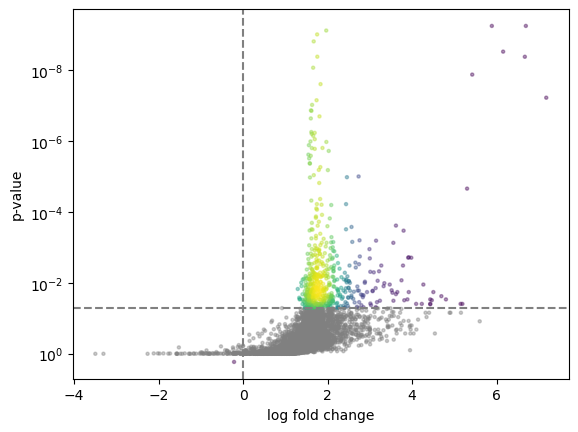

In [37]:
plot_volcano(fold_change_beta, pval_threshold=0.05, fold_change_threshold=0)

In [42]:
selected_clones = fold_change_beta[(fold_change_beta.pval < 0.05) & (fold_change_beta.log_fold_change > 0)].clone

In [43]:
selected_clones

0        CSVGTGGTNEKLFF
10        CASSSGPNTEAFF
11       CSVGSGGTNEKLFF
15         CASSLGYTEAFF
16        CASSQGGGTEAFF
             ...       
5163     CASSEAGAIGGYTF
5188    CASSFYRDSNQPQHF
5192     CASSERGVNQPQHF
5207     CASSELGVNQPQHF
5218    CASSFGGGRGYGYTF
Name: clone, Length: 602, dtype: object

In [27]:
beta_cm

,CSVGTGGTNEKLFF,CASSVGGNTEAFF,CASSSANYGYTF,CASSIRSSYEQYF,CASSVGGGTEAFF,CASSEDGMNTEAFF,CSARDRTGNGYTF,CASSLAPGATNEKLFF,CASSQSPGGTQYF,CSARDGTGNGYTF,...,CASSFGGARGYGYTF,CASSFGGDRGYGYTF,CASSFDRGQGGYTF,CASSFDRATNEKLFF,CASSFGTGIDEKLFF,CASSFGGGRGYGYTF,CASSETSGAGDTQYF,CASGDSLNQPQHF,CASGESGGNQPQHF,run
0,0,1,1,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,020000010808_S3_L001
1,0,5,1,0,10,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,020000420808_S51_L001
2,1,7,3,0,5,3,0,0,0,0,...,0,0,0,1,0,0,0,0,1,050000200808_S157_L002
3,0,3,0,0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,270000010808_S182_L002
4,0,6,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,020003810808_S104_L002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,0,5,1,0,6,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2,210002850808_S120_L002
952,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,640003580808_S34_L001
953,0,4,0,1,2,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,640002220808_S31_L001
954,2,6,3,2,2,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,640002920808_S23_L001


In [28]:
data_beta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_allele.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=False, 
                     make_all_features_bool=False, 
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',)

In [44]:
data_beta = data_beta[list(selected_clones) + ['covid', 'is_test_run']]

In [45]:
X_train, y_train, X_test, y_test = split_data(data=data_beta, y_column='covid', by='is_test_run')
best_clfs_beta = evaluate_models(X_train, y_train, X_test, y_test, get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 5, 'model__kernel': 'sigmoid', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.59

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=3), 'model__n_estimators': 125, 'model__random_state': 42}
Test f1-score for the best model 0.61

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 3, 'model__weights': 'uniform'}
Test f1-score for the best model 0.37

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 1e-05, 'model__hidden_layer_sizes': (150, 100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_st

In [48]:
best_clfs_beta[0]['xgboost'].score(X_test, y_test)

0.5603448275862069